In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import clear_output, display, HTML
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# This line is a work around for an error when viewing dataframes
#get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [3]:
import pandas as pd
#from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
df=pd.read_csv(r'data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')

classes = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
groupwise = []
y=np.argmax(df[classes].to_numpy(),axis=1)
print(y[:10])
w = compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
print(w)
for class_ in classes:
    groupwise.append(df[df[class_]==1.0])
for name,group in zip(classes,groupwise):
    print(name,':',len(group))
    
np.random.seed(50)
train = None
test = None
validate = None
for g in groupwise:
    tr,te,va = np.split(g, [int(.95*len(g)), int(.96*len(g))])
    #print(tr)
    if train is not None:
        train =train.append(tr)
    else:
        train = tr
    if test is not None:
        test = test.append(te)
    else:
        test = te
    if validate is not None:
        validate = validate.append(va)
    else:
        validate = va

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validate = validate.sample(frac=1).reset_index(drop=True)
        
print('train count:',len(train))
print('train:\n',train.head())
print('test count:',len(test))
print('test:\n',test.head())
print('validate count',len(validate))
print('validate:\n',validate.head())

[1 1 1 1 0 1 4 0 1 0]
[ 1.285458  0.21338   2.783491  4.375273  1.301833 12.440994 10.075453]
MEL : 1113
NV : 6705
BCC : 514
AKIEC : 327
BKL : 1099
DF : 115
VASC : 142
train count: 9511
train:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0031583  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0025666  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0027174  1.0  0.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0029955  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0026651  0.0  1.0  0.0    0.0  0.0  0.0   0.0
test count: 100
test:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0033861  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0033826  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0033822  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0033825  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0033839  0.0  1.0  0.0    0.0  0.0  0.0   0.0
validate count 404
validate:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0034090  0.0  1.0  0.0    0.0  0.0  0.0   0

In [4]:
df = df.sample(frac=1).reset_index(drop=True)
print('total count:',len(df))
print('a few samples from csv:\n',df.head())

total count: 10015
a few samples from csv:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0030972  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0029180  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0028105  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0027406  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0025111  0.0  1.0  0.0    0.0  0.0  0.0   0.0


In [5]:
data = ImageDataBunch.from_df(path='data', ds_tfms=get_transforms(), df=df,size=128, bs=128, suffix='.jpg', 
                               folder='ISIC2018_Task3_Training_Input', fn_col='image',label_col=classes,
                               valid_pct=0.05,test='ISIC2018_Task3_Test_Input').normalize(imagenet_stats)
                              

In [6]:
def getLearner():
    return create_cnn(data, models.resnet50, pretrained=True, metrics=error_rate,
                      callback_fns=ShowGraph)

learner = getLearner()

In [7]:
# Code below is to find best weight decay rate

lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


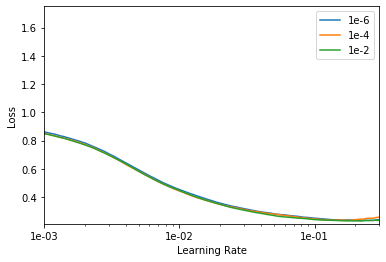

In [8]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.8
max_y = 1.75
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [10]:
max_lr = slice(5e-3,3e-2)
wd = 1e-4

epoch,train_loss,valid_loss,error_rate,time
0,0.419734,0.178382,0.830857,00:19
1,0.219774,0.169056,0.751714,00:18
2,0.165191,0.131296,0.851429,00:19
3,0.140750,0.132675,0.872286,00:18
4,0.125775,0.118371,0.825143,00:19
5,0.113197,0.104929,0.826857,00:18
6,0.097404,0.099566,0.825429,00:18
7,0.086196,0.100435,0.822286,00:19


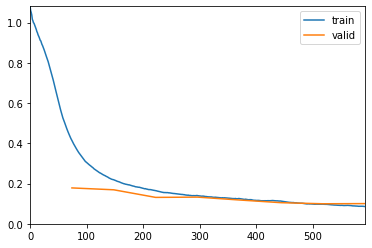

In [11]:
learner.fit_one_cycle(cyc_len=8, 
                      max_lr=max_lr, 
                      wd=wd)

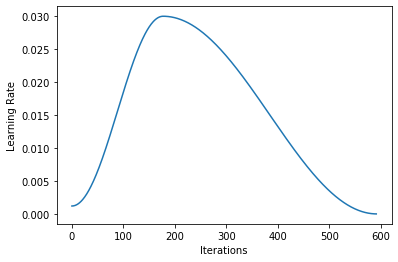

In [12]:
learner.recorder.plot_lr()

In [13]:
learner.save('Resnet50_wd_128_fit1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


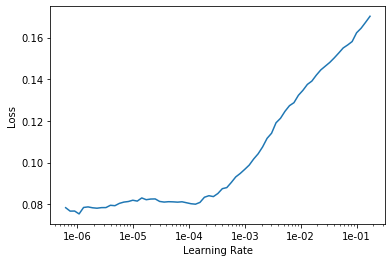

In [14]:
# load the baseline model
learner.load('Resnet50_wd_128_fit1')

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.079996,0.099023,0.824857,00:22
1,0.079184,0.099763,0.826286,00:22
2,0.078207,0.098047,0.827143,00:22
3,0.078157,0.097854,0.821429,00:22
4,0.077716,0.097235,0.823714,00:22
5,0.076765,0.097502,0.827714,00:22
6,0.077472,0.096849,0.827714,00:22
7,0.072913,0.096530,0.823714,00:22
8,0.072754,0.096308,0.823143,00:22
9,0.073207,0.095756,0.825714,00:22


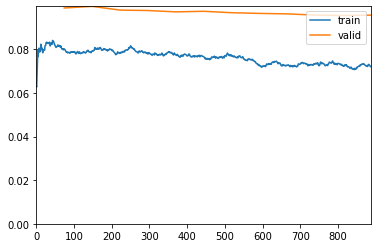

In [15]:
# Entered unintended learning rates here
learner.fit_one_cycle(cyc_len=12, max_lr=slice(1e-7,1e-5))
#learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

In [16]:
learner.save('resnet50_128_wd')

In [17]:
learner.load('resnet50_128_wd')

Learner(data=ImageDataBunch;

Train: LabelList (9515 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
NV,NV,NV,NV,NV
Path: data;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
NV,NV,NV,BKL,MEL
Path: data;

Test: LabelList (1512 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_s

epoch,train_loss,valid_loss,error_rate,time
0,0.072678,0.096006,0.826000,00:22
1,0.073120,0.094456,0.821143,00:22
2,0.070746,0.097677,0.832571,00:22
3,0.066371,0.100135,0.828000,00:22
4,0.059463,0.095127,0.817143,00:22
5,0.055229,0.090784,0.821429,00:22
6,0.050876,0.093982,0.817429,00:22
7,0.047770,0.095565,0.815143,00:22


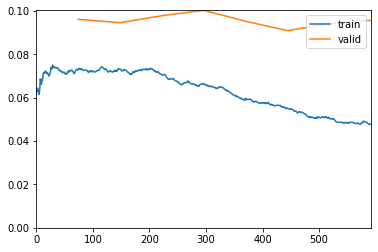

In [18]:
# Fixed learning rate here which proved to have the lowest error rate and best balance between train and val losses
learner.fit_one_cycle(cyc_len=8, max_lr=slice(7e-6,6e-5))

In [19]:
interp = ClassificationInterpretation.from_learner(learner)

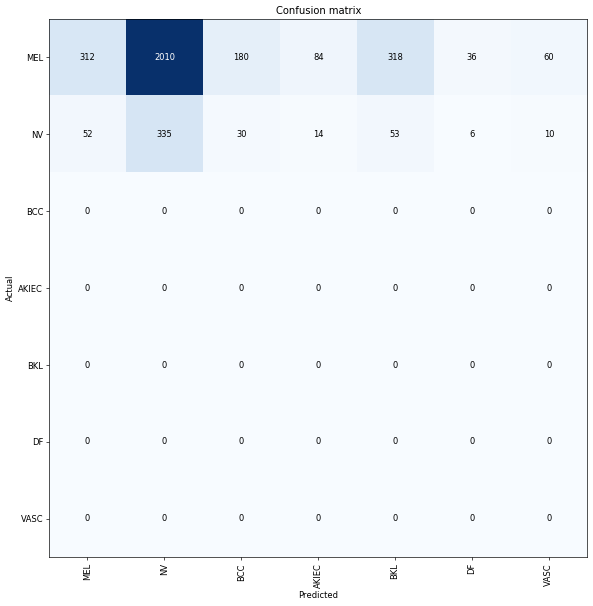

In [20]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [21]:
from sklearn.metrics import balanced_accuracy_score
val_preds,val_y = learner.TTA(ds_type=DatasetType.Valid)
val_preds,val_y = np.argmax(val_preds,axis=1),np.argmax(val_y,axis=1)
bas = balanced_accuracy_score(val_y,val_preds)
print(bas)

0.7609335545832513


In [23]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(val_y,val_preds)
print(cm)

[[ 32  19   3   4   3   0   0]
 [  6 317   2   1   4   0   1]
 [  0   2  22   1   0   0   0]
 [  1   0   1   9   3   0   0]
 [  3   8   1   1  40   0   0]
 [  0   2   0   0   0   4   0]
 [  0   1   0   0   0   0   9]]


In [24]:
from sklearn.metrics import classification_report
cr=classification_report(val_y,val_preds)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.52      0.62        61
           1       0.91      0.96      0.93       331
           2       0.76      0.88      0.81        25
           3       0.56      0.64      0.60        14
           4       0.80      0.75      0.78        53
           5       1.00      0.67      0.80         6
           6       0.90      0.90      0.90        10

    accuracy                           0.87       500
   macro avg       0.81      0.76      0.78       500
weighted avg       0.86      0.87      0.86       500



In [26]:
bal_acc=((
    cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2]+cm[0][3]+cm[0][4]+cm[0][5]+cm[0][6]) + 
    cm[1][1]/(cm[1][0]+cm[1][1]+cm[1][2]+cm[1][3]+cm[1][4]+cm[1][5]+cm[1][6]) +
    cm[2][2]/(cm[2][0]+cm[2][1]+cm[2][2]+cm[2][3]+cm[2][4]+cm[2][5]+cm[2][6]) +
    cm[3][3]/(cm[3][0]+cm[3][1]+cm[3][2]+cm[3][3]+cm[3][4]+cm[3][5]+cm[3][6]) +
    cm[4][4]/(cm[4][0]+cm[4][1]+cm[4][2]+cm[4][3]+cm[4][4]+cm[4][5]+cm[4][6]) +
    cm[5][5]/(cm[5][0]+cm[5][1]+cm[5][2]+cm[5][3]+cm[5][4]+cm[5][5]+cm[5][6]) +
    cm[6][6]/(cm[6][0]+cm[6][1]+cm[6][2]+cm[6][3]+cm[6][4]+cm[6][5]+cm[6][6]) 
    )/7)
print(bal_acc)

0.7609335545832513


In [25]:
print(val_preds)
print(val_y)

tensor([1, 1, 1, 1, 1, 1, 1, 2, 1, 1])
tensor([0, 0, 1, 0, 1, 1, 0, 2, 0, 1])


In [27]:
learner.export('trained_model.pkl')

In [74]:
path = learner.path
path

PosixPath('.')

In [70]:
val_preds,y=learner.get_preds(data2)

In [54]:
print(type(val_preds))
val_preds=torch.argmax(val_preds,dims=1)

<class 'list'>


TypeError: argmax(): argument 'input' (position 1) must be Tensor, not list

In [43]:
print(train[classes].to_numpy())

[[0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [45]:
val_y=np.argmax(train[classes].to_numpy(),axis=1)


In [46]:
print(val_y[:10])
print(val_preds[:10])

[1 1 0 1 1 1 1 1 4 0]
[[70  9  8 25 15 26 39]
 [27  0  8 25  7 26 23]]


In [71]:
bas = balanced_accuracy_score(torch.argmax(y,axis=1),torch.argmax(val_preds,axis=1))
print(bas)

1.0


epoch,train_loss,valid_loss,error_rate,time
0,0.048507,0.096339,0.816571,00:22
1,0.048764,0.098636,0.803714,00:22
2,0.047978,0.101941,0.811429,00:22
3,0.044188,0.098749,0.814000,00:22
4,0.041412,0.102919,0.816000,00:22
5,0.036681,0.096505,0.813143,00:22
6,0.032492,0.098266,0.811429,00:22
7,0.032427,0.098009,0.814571,00:22


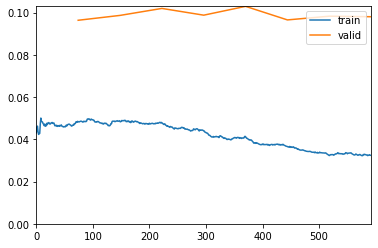

In [28]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(7e-6,6e-5))

In [29]:
test_files = data.test_ds.x

In [30]:
print(test_files)

ImageList (1512 items)
Image (3, 450, 600),Image (3, 450, 600),Image (3, 450, 600),Image (3, 450, 600),Image (3, 450, 600)
Path: data


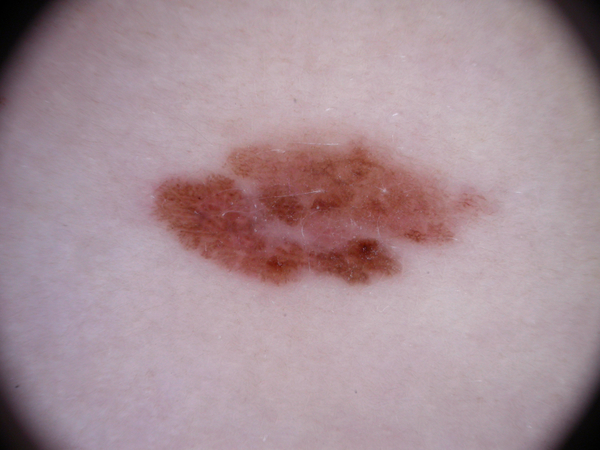

In [33]:
img=test_files[0]
img

In [48]:
np.set_printoptions(suppress=True)
preds, _ = learner.get_preds(ds_type=DatasetType.Test)
labels = preds.numpy()
test_index = []
num = len(learner.data.test_ds)
for i in range(num):
    test_index.append(str(learner.data.test_ds.items[i]).split('/')[-1])
df_test = pd.DataFrame(labels,columns=classes)

In [49]:
df_test.insert(0,'image',test_index)
print(df_test.head())

              image       MEL        NV           BCC         AKIEC  \
0  ISIC_0035868.jpg  0.001528  0.999119  1.092802e-06  6.631381e-06   
1  ISIC_0035930.jpg  0.011777  0.984750  4.864311e-04  3.507536e-04   
2  ISIC_0035542.jpg  0.000020  0.999997  1.405985e-08  5.191338e-07   
3  ISIC_0035123.jpg  0.007825  0.993564  5.141847e-06  6.638552e-04   
4  ISIC_0035684.jpg  0.000331  0.999929  1.842215e-06  3.040072e-07   

            BKL            DF          VASC  
0  6.225006e-06  4.482449e-08  6.662771e-07  
1  7.081395e-04  6.619023e-06  2.952509e-05  
2  8.000709e-07  2.073361e-09  8.737438e-09  
3  2.086052e-04  1.502090e-04  5.139450e-06  
4  1.911818e-06  1.091192e-06  1.478996e-07  


In [50]:
df_test.to_csv('test_results_for_submission.csv',index=False)